# Comparing Point Clouds

In this notebook, we use decorated merge trees to compare toy point cloud data. The experiments here correspond to Figures 1 and 11 from our paper:

[1] *Decorated Merge Trees for Persistenct Topology* by Justin Curry, Haibin Hang, Washington Mio, Tom Needham and Osman Okutan. [Arxiv](https://arxiv.org/abs/2103.15804). The paper has been published in [Journal of Applied and Computational Topology](https://link.springer.com/article/10.1007/s41468-022-00089-3).

We will refer back to specific sections of this paper throughout the notebook. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
import persim
import networkx as nx
from sklearn import manifold

from DMT_tools import *
from example_generating_functions import *

import ot

import time

import warnings
warnings.filterwarnings("ignore")

## Visualizing DMTs and Persistence Diagrams

This section corresponds to Figure 1 of [1].

We first generate some point clouds whose degree-0 and degree-1 persistent homology barcodes are similar, despite the point clouds having overall different topological structure.

Note that we are using custom functions for generating toy point cloud data from `example_generating_functions.py`.

In [2]:
# Generating 2d point cloud data

point_clouds = []

point_clouds.append(three_clusters_variable_circles(['circle','disk','circle','circle'],[1.5,1,1,2],4,3))
point_clouds.append(three_clusters_variable_circles(['circle','circle','disk','circle'],[1.5,1,1,2],4,3))

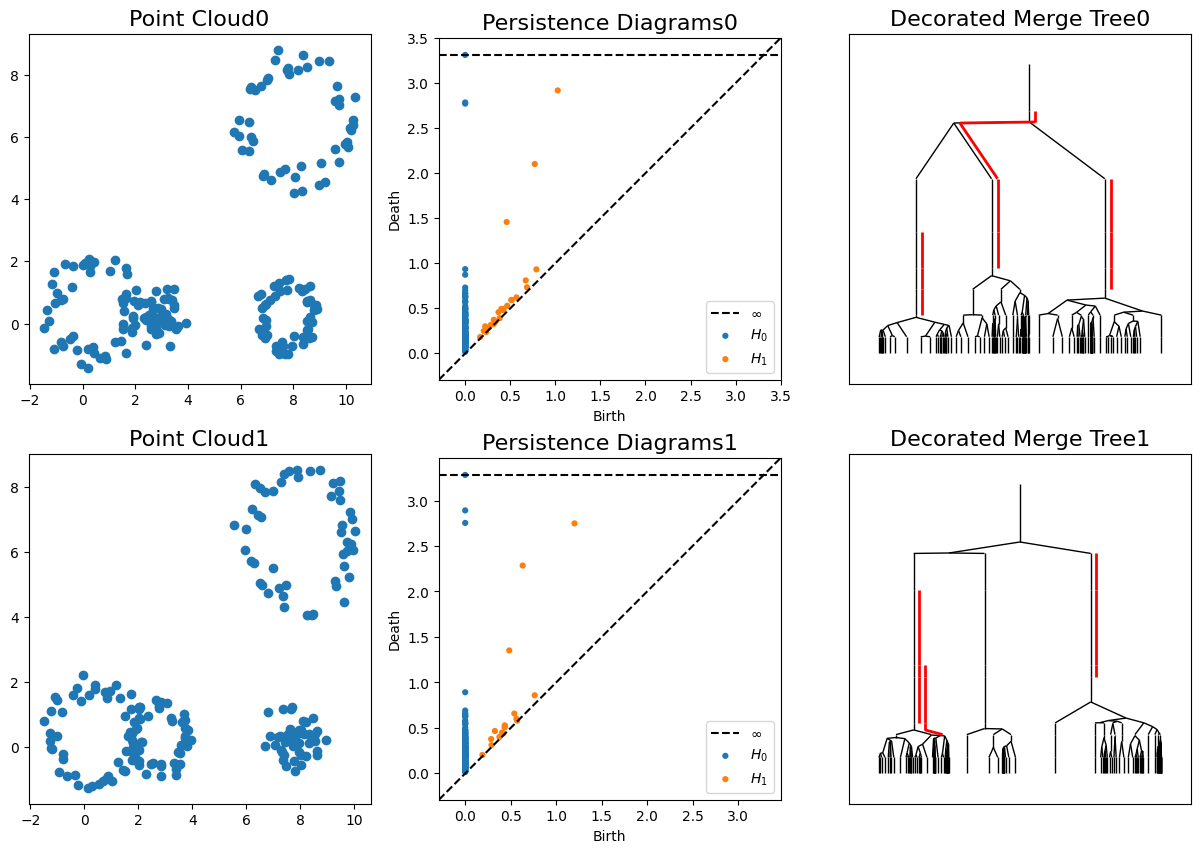

In [3]:
# Visualizing TDA signatures of the point clouds

fig, axs = plt.subplots(2, 3, figsize = (15,10))
    
for j,data in enumerate(point_clouds):
    
    # Plot point cloud

    ax = axs[j,0]
    ax.set_title('Point Cloud'+str(j),fontsize = 16)
    ax.scatter(data[:,0],data[:,1])
    
    # Plot persistence diagrams

    ax = axs[j,1]
    ax.set_title('Persistence Diagrams'+str(j),fontsize = 16)
    dgms = ripser(data)['dgms']
    persim.plot_diagrams(dgms, ax = ax)
    
    # Plot decorated merge trees
    # Note: the merge tree class has a built in visualization method, but we are doing it
    # 'by hand' here to fit into the overall figure

    ax = axs[j,2]
    ax.set_title('Decorated Merge Tree'+str(j),fontsize = 16)
    ax.tick_params(left=True, bottom=False, labelleft=True, labelbottom=False)
    
    MT = MergeTree(pointCloud = data)
    
    tree_thresh = 0.2 # Simplification parameter for visualization
    barcode_thresh = 0.4 # Simplification parameter for visualization
    T_DMT, pos_DMT, edges, colors, weights = visualize_DMT_pointcloud(MT.tree,
                                                                      MT.height,
                                                                      dgms[1],
                                                                      data,
                                                                      tree_thresh,
                                                                      barcode_thresh,
                                                                      offset = .02,
                                                                      draw = False)
    nx.draw_networkx(T_DMT, 
                     pos = pos_DMT, 
                     edge_color=colors, 
                     width=weights,
                     node_size = 0,
                     with_labels = False,
                     ax = ax)
        

fig.show()

Observe in the above figure that the point clouds are not easily distinguished by their persistence diagrams (in either dimension), but that they are easily distinguished by their DMTs!

## Clustering Point Clouds with DMTs

Now we run a more quantitative experiment: we create 6 different classes of 2d point clouds, generate a few samples from each class and then compute the pairwise distance matrix for all samples using various TDA signatures. 

This experiment replicates Figure 11 of [1].

The point clouds are deliberately chosen to be confusing for degree-0 and degree-1 TDA features. Parameters and models can be changed below.

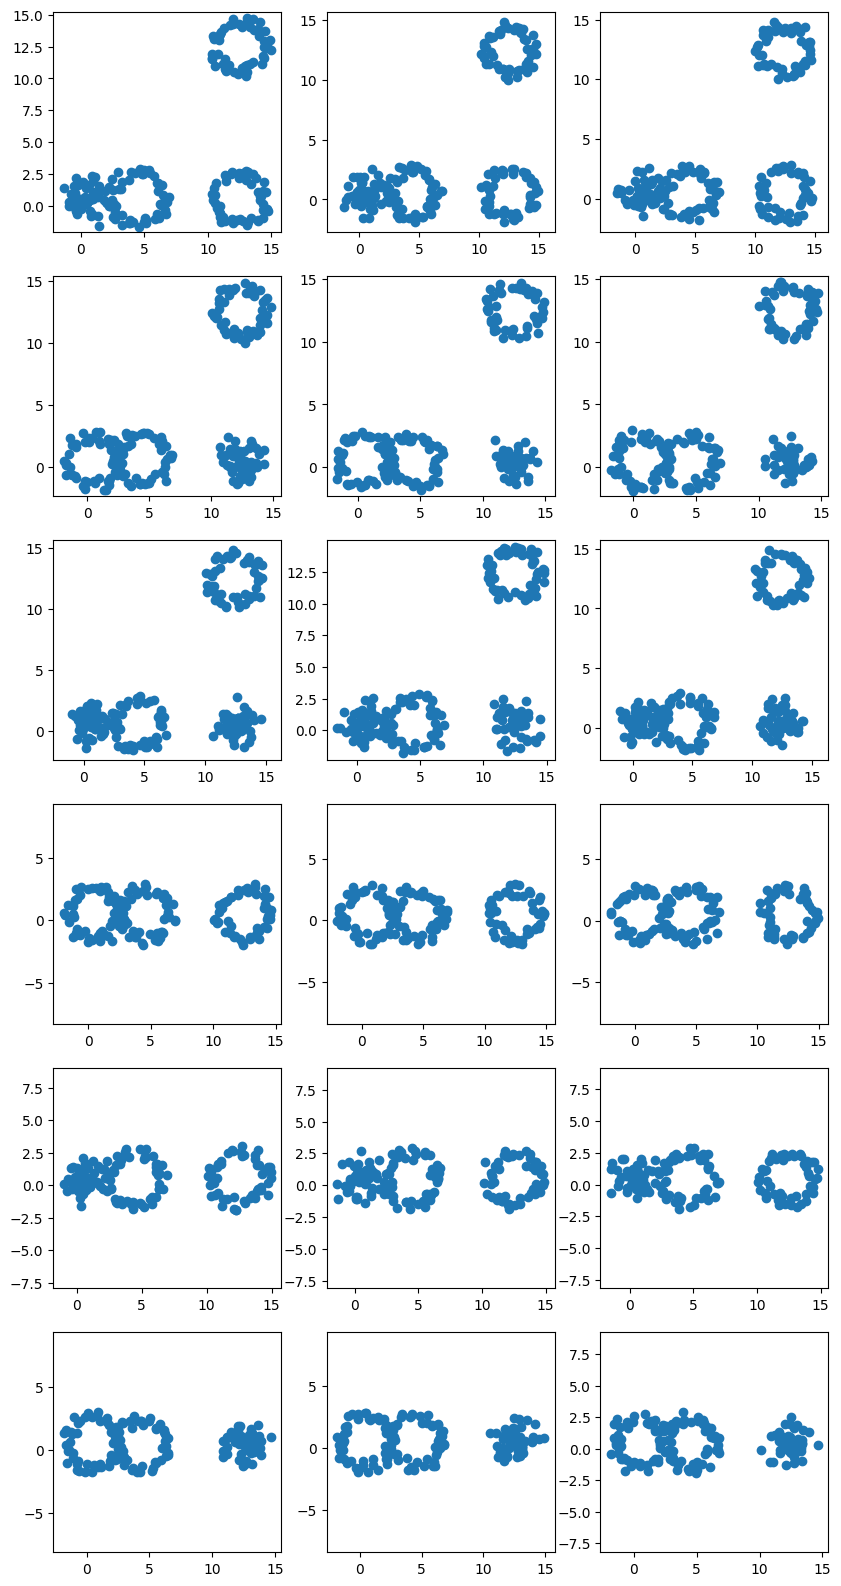

In [4]:
# Generate point clouds

base_rad = 2
base_sep1 = 6
base_sep2 = 8
pert1 = 0
pert2 = 0

templates = [three_clusters_variable_circles(['disk','circle','circle','circle'],[base_rad,base_rad,base_rad,base_rad],base_sep1,base_sep2),
            three_clusters_variable_circles(['disk','circle','circle','circle'],[base_rad,base_rad,base_rad,base_rad+pert1],base_sep1,base_sep2+pert1),
            three_clusters_variable_circles(['disk','circle','circle','circle'],[base_rad,base_rad,base_rad,base_rad+pert2],base_sep1,base_sep2+pert2),
            three_clusters_variable_circles(['circle','circle','disk','circle'],[base_rad,base_rad,base_rad,base_rad],base_sep1,base_sep2),
            three_clusters_variable_circles(['circle','circle','disk','circle'],[base_rad,base_rad,base_rad,base_rad+pert1],base_sep1,base_sep2+pert1),
            three_clusters_variable_circles(['circle','circle','disk','circle'],[base_rad,base_rad,base_rad,base_rad+pert2],base_sep1,base_sep2+pert2),
            three_clusters_variable_circles(['disk','circle','disk','circle'],[base_rad,base_rad,base_rad,base_rad],base_sep1,base_sep2),
            three_clusters_variable_circles(['disk','circle','disk','circle'],[base_rad,base_rad,base_rad,base_rad+pert1],base_sep1,base_sep2+pert1),
            three_clusters_variable_circles(['disk','circle','disk','circle'],[base_rad,base_rad,base_rad,base_rad+pert2],base_sep1,base_sep2+pert2),
            two_clusters_variable_circles(['circle','circle','circle'],[base_rad,base_rad,base_rad],base_sep1),
            two_clusters_variable_circles(['circle','circle','circle'],[base_rad,base_rad,base_rad],base_sep1),
            two_clusters_variable_circles(['circle','circle','circle'],[base_rad,base_rad,base_rad],base_sep1),
            two_clusters_variable_circles(['disk','circle','circle'],[base_rad,base_rad,base_rad,base_rad],base_sep1),
            two_clusters_variable_circles(['disk','circle','circle'],[base_rad,base_rad,base_rad],base_sep1),
            two_clusters_variable_circles(['disk','circle','circle'],[base_rad,base_rad,base_rad],base_sep1),
            two_clusters_variable_circles(['circle','circle','disk'],[base_rad,base_rad,base_rad],base_sep1),
            two_clusters_variable_circles(['circle','circle','disk'],[base_rad,base_rad,base_rad],base_sep1),
            two_clusters_variable_circles(['circle','circle','disk'],[base_rad,base_rad,base_rad],base_sep1)]

plt.figure(figsize = (10,20))

num_templates = len(templates)

for j in range(num_templates):
    plt.subplot(6,3,j+1)
    data = templates[j]
    plt.scatter(data[:,0],data[:,1])
    plt.axis('equal')
    
plt.show()

In [5]:
# Pairwise distance matrices and compute times

methods = ['deg0','deg1','int']

distMats = {}
times = {}

for method in methods:
    distMats[method] = np.zeros([len(templates),len(templates)])
    times[method] = 0

threshold = 2 # Simplification parameter for merge tree interleaving
              # Large threshold speeds up computation but may give less accurate results

for i,data_i in enumerate(templates):
    
    print('Starting Row',i)
    
    dgms_i = ripser(data_i)['dgms']
    dgm0_i = dgms_i[0]
    dgm1_i = dgms_i[1]
    MT_i = MergeTree(pointCloud = data_i)
    MT_i.fit_barcode(degree = 1)
    MT_i.threshold(threshold)
    
    for j in range(i+1,len(templates)):
        
            data_j = templates[j]
            
            dgms_j = ripser(data_j)['dgms']
            dgm0_j = dgms_j[0]
            dgm1_j = dgms_j[1]
            MT_j = MergeTree(pointCloud = data_j)
            MT_j.fit_barcode(degree = 1)
            MT_j.threshold(threshold)
            
            start = time.time()
            distMats['deg0'][i,j] = bottleneck(dgm0_i,dgm0_j)
            times['deg0'] += time.time() - start
            
            start = time.time()
            distMats['deg1'][i,j] = bottleneck(dgm1_i,dgm1_j)
            times['deg1'] += time.time() - start
            
            start = time.time()
            res = DMT_interleaving_distance(MT_i,MT_j,1,verbose = True)
            
            distMats['int'][i,j] = res['dist']
            times['int'] += time.time() - start
            
for method in methods:
    distMats[method] += distMats[method].T
    times[method] = np.round(times[method],2)

Starting Row 0
Starting Row 1
Starting Row 2
Starting Row 3
Starting Row 4
Starting Row 5
Starting Row 6
Starting Row 7
Starting Row 8
Starting Row 9
Starting Row 10
Starting Row 11
Starting Row 12
Starting Row 13
Starting Row 14
Starting Row 15
Starting Row 16
Starting Row 17


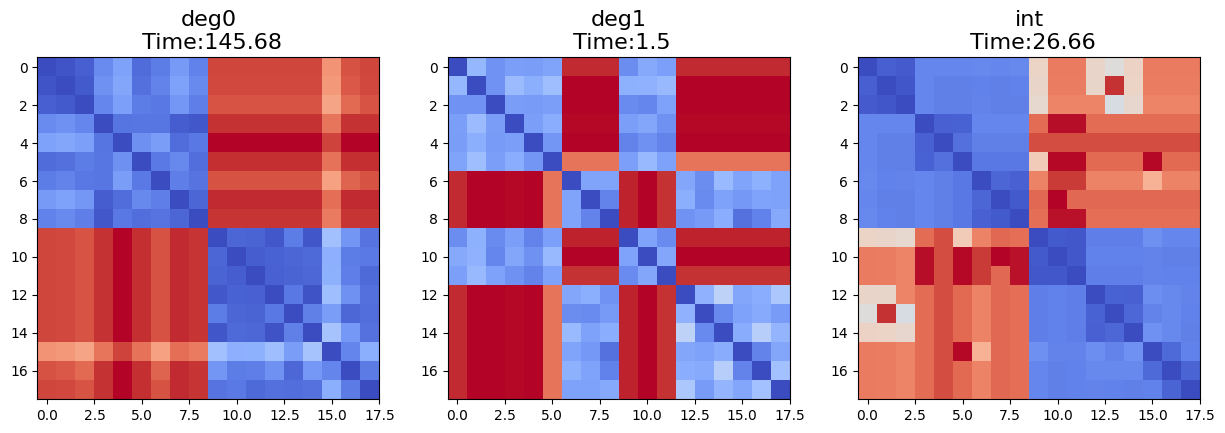

In [6]:
plt.figure(figsize = (15,5))

for j,method in enumerate(methods):
    plt.subplot(1,3,j+1)
    Dist = distMats[method]
    plt.imshow(Dist, cmap = plt.cm.coolwarm)
    t = times[method]
    plt.title(method+'\n Time:'+str(t),fontsize = 16)

plt.show()

We see that the decorated merge tree interleaving distance is able to distinguish the classes. This is also illustrated in the apparent clustering in the MDS plots below.

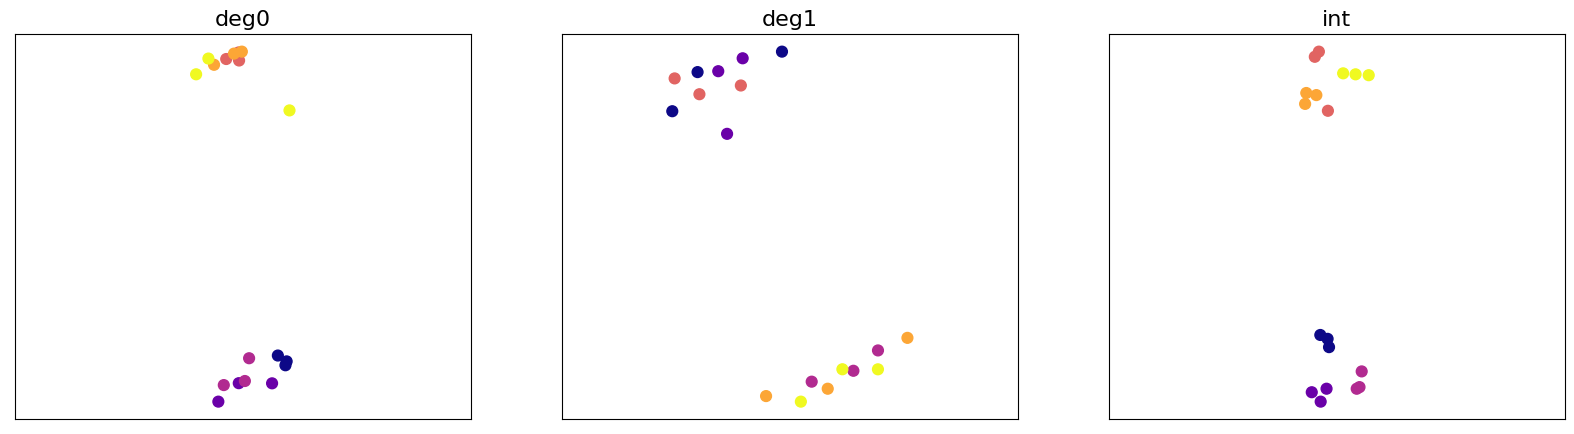

In [7]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed")
labels = 3*[0] + 3*[1] + 3*[2] + 3*[3] + 3*[4] + 3*[5]

plt.figure(figsize = (20,5))

for j,method in enumerate(methods):
    plt.subplot(1,3,j+1)
    Dist = distMats[method]
    results = mds.fit(Dist)
    coords = results.embedding_
    plt.title(method,fontsize = 16)
    plt.xticks([])
    plt.yticks([])
    plt.scatter(coords[:,0],coords[:,1],c = labels, cmap = plt.cm.plasma, s = 60)
    plt.axis('equal')

plt.show()